<a href="https://colab.research.google.com/github/aspyridakos/Speechbrain-MOABB-EEG-Processing/blob/main/COMP_432_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EEG-Based Motor Imagery Decoding with Deep Learning**
**Author:** Alexandra Spyridakos, 40175280

**Date:** April 20th, 2024

## **Abstract**
   This project aims to find machine learning models tasked to decode EEG motor imagery data with more accuracy than the provided benchmarks of existing EEGNet models in SpeechBrain-MOAB's library for the BNCI2014_001 dataset. The main methods used were (1) preprocessing data into three sets; a trainng set, a validation set, and a test set, (2) defining the model, (3) finding optimal hyperparameters, (4) training the model, and (5) running the model on the entire dataset to determine new model accuracy benchmarks. In the end, the model with the best performance, though only  marginally better than the original EEGNet benchmarks (+1%) was CustomModel3, which implemented depthwise separable 2D convolutions instead of the standard 2D convolutional layers. Upon comparing all the custom models created, it was determined that simpler architectures outperformed more complex architectures when benchmarking the different models. No conclusions could be drawn as to whether CustomModel3 was indeed better than EEGNet as further experimentation is required.


## **Introduction**

The goal of this project is to find effective and efficient machine learning models to decode EEG motor imagery data. This project if successful could positively contribute to creating new technologies to support those with disabilities such as ALS, Parkinsons, quadriplegia, etc. whose motor function may be impeded by physical or neurological limitations. Some of the main challenges faced in decoding EEG signals is that they can be impacted by other external stimuli so isolating movements from other reactions to a test subject's environment can be quite difficult. Additionally, everyone's EEG signals are a little bit different, for this reason we need machine learning algorithms to find patterns in these diverse datasets and filter out the noise in the data model which would be otherwise impossible to do manually in a reasonable amount of time.

Currently, studies on EEG models suggest using convolutional neural networks for more shallow models [1], with a strong preference for 2D batch normalization as the predominant normalization technique used alongside 2D convolutions [1]. Additionally, the latest release of SpeechBrain's EEGNet model [2, Fig. 1] for the BCNI2014_001 dataset, having an accuracy of approximately 73%, uses a less complex layering architecture [2]. For these reasons, a simple architecture layering with 2D convolutional layers paired with batch normalization will serve as a base in the custom models of this project. Custom models will build off of the existing EEGNet model from SpeechBrain-MOABB presented in [2, Fig.1] below as a means to improve existing research by attempting to exceed the accuracy benchmarks achieved in prior releases of the EEGNet model.

|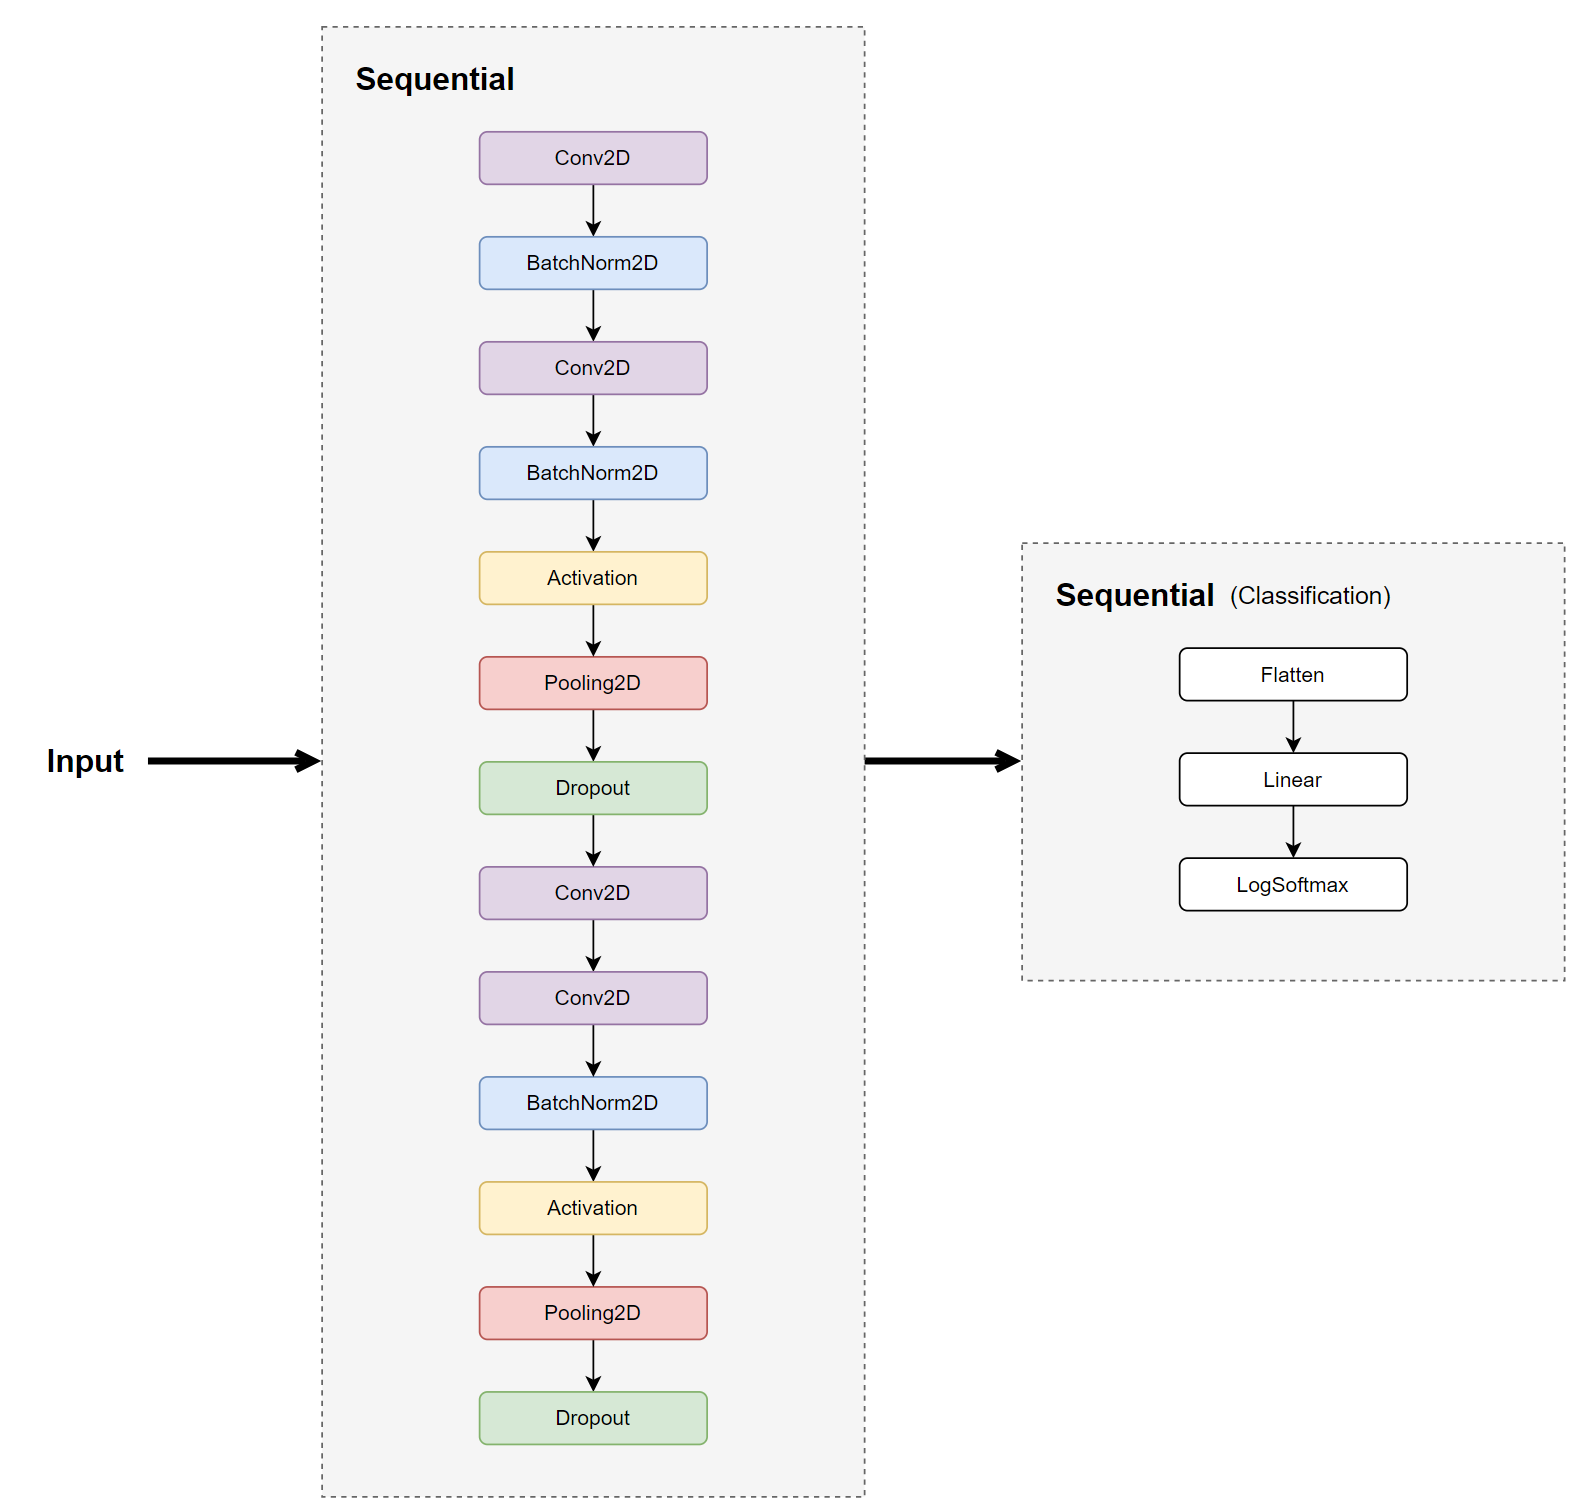|
|:--:|
|Fig.1. EEGNet Architecture [2]|

The best custom model was CustomModel3 with an accuracy of 74.5945% ± 0.236%, with main differences from EEGNet being the replacement of one of the 2D convolutional layers for a depthwise separable 2D convolutional layer and the replacement of the last pooling layer with `AvgPooling2D` from `torch.nn`.

## **Methodology**
To create a custom model in this experiment, the main steps taken were:
1. Researching existing work and getting familiar with the SpeechBrain-MOABB library and BNCI2014_001 dataset
2. Creating a model pulling ideas from existing research and experimenting with new ideas (EEGNet's model was used as template to formulate new models)
3. Define YAML file of hyperparameters to train the model with (start with provided ones from EEGNet as a default)
4. Preprocess BNCI2014_001 dataset into a training set, validation set and test set (using leave-one-session-out mode in `run_experiments.sh` script)
5. Run hyperparameter tuning using Orion
6. Update hyperparams file with new optimal parameters
7. Train model using tuned hyperparameters
8. Run experiments (one subject run if accuracy was low in Orion tuning step, otherwise all subjects)


Here two main resources were used as reference in creating custom models [1] and [2].

As can be seen in the table below, the architecture of a model from [1, Fig. 2] has 2 main blocks (simpler architecture). Both this model and the SpeechBrain MOABB model references above, `Conv2` is used with `BatchNorm`, followed by an activation function, a pooling layer, and a dropout layer. Architectures containing multiple convolutional layers typically stack these with a normalization layer before applying activation functions. Finally after all blocks, the data is flattened and passed through a dense layer and softmax. For the activation layers a strong preference for ELU can be noted in both models presented.


|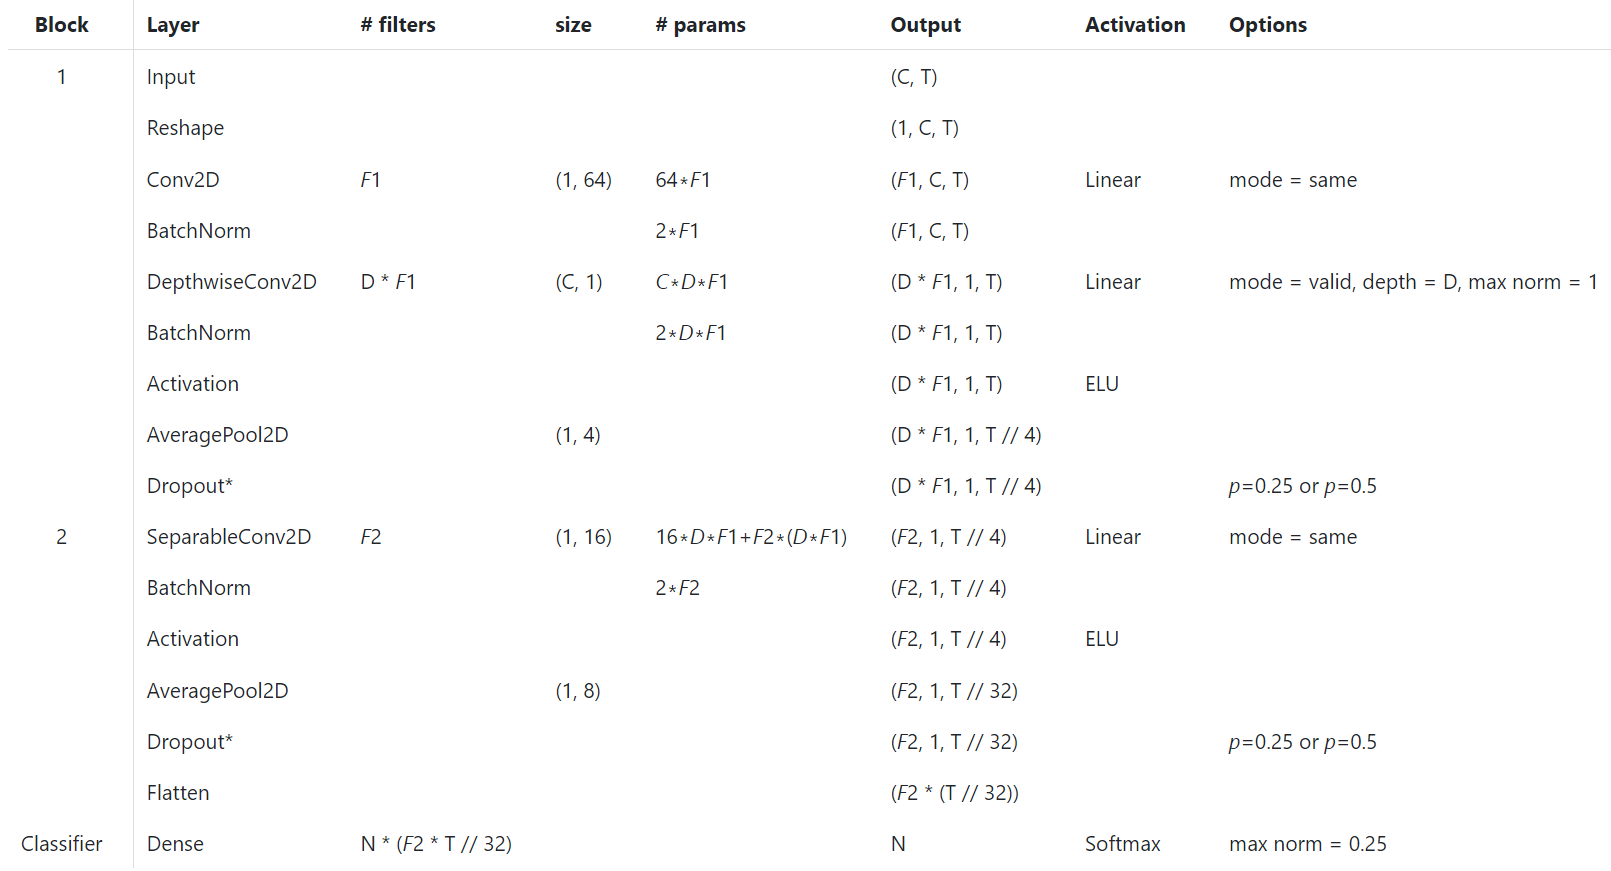|
|:--:|
|Fig.2. Shallow EEGNet model [1]|


The more accurate custom models that are proposed in this project leverage using simplified architecture layering, as well as `BatchNorm`, `Conv2D` and `DepthwiseConv2D` as seen in [1, Fig.2]. There is also some experimentation in the models that increase the number of convolutional layers, use `GroupNorm` for normalization, `AdaptiveAvgPool2d` and `StatisticsPooling` for pooling layer, and `GumbelSoftmax` instead of the existing `LogSoftmax` from the EEGNet model for the dense module. For a more clear visual of all custom model architectures described, please refer to the architecture diagrams attatched below.

|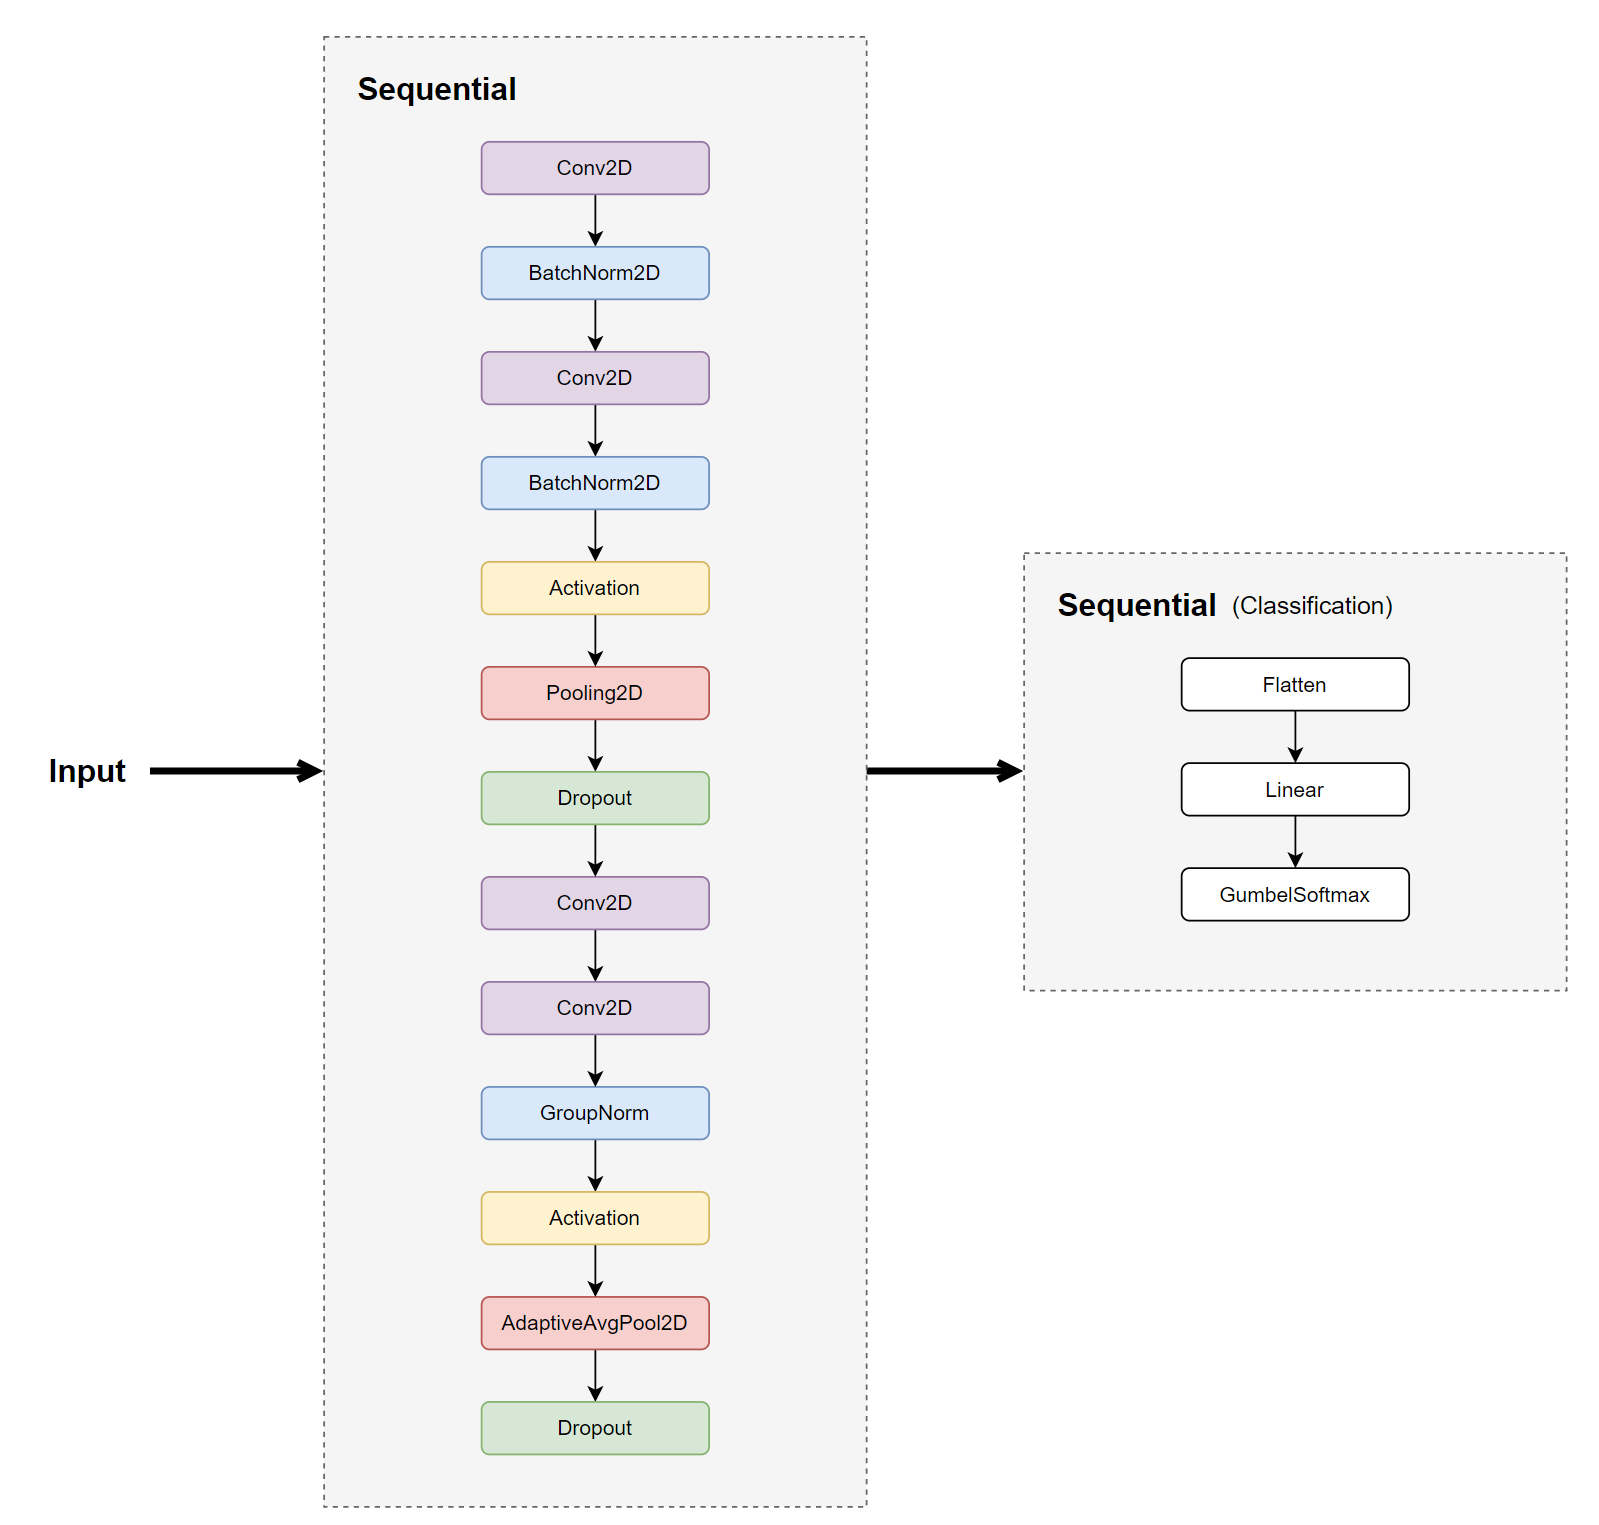|
|:--:|
|Fig.3. CustomModel1 Architecture Diagram|

|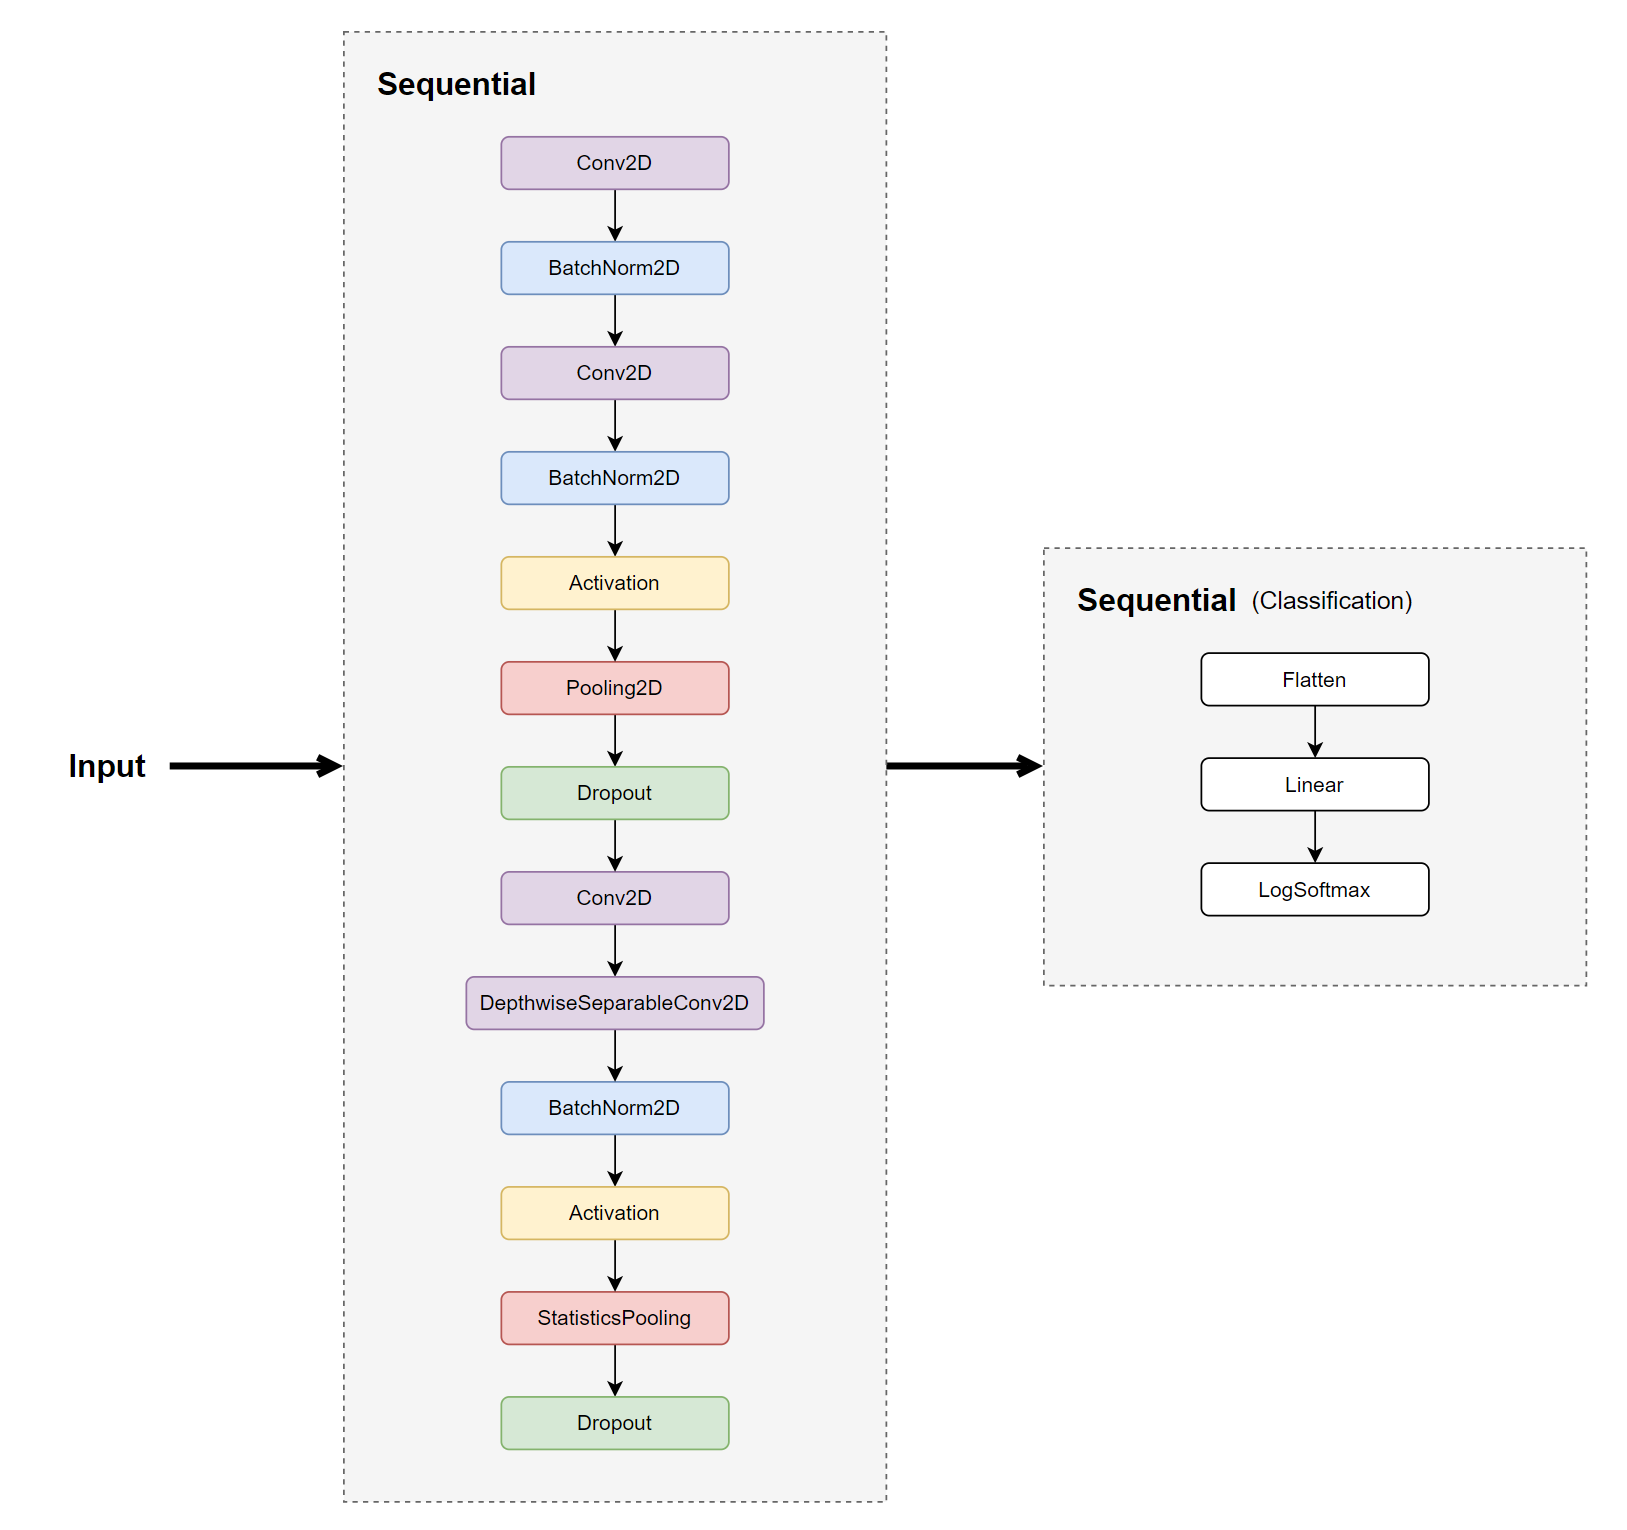|
|:--:|
|Fig.4. CustomModel2 Architecture Diagram|

|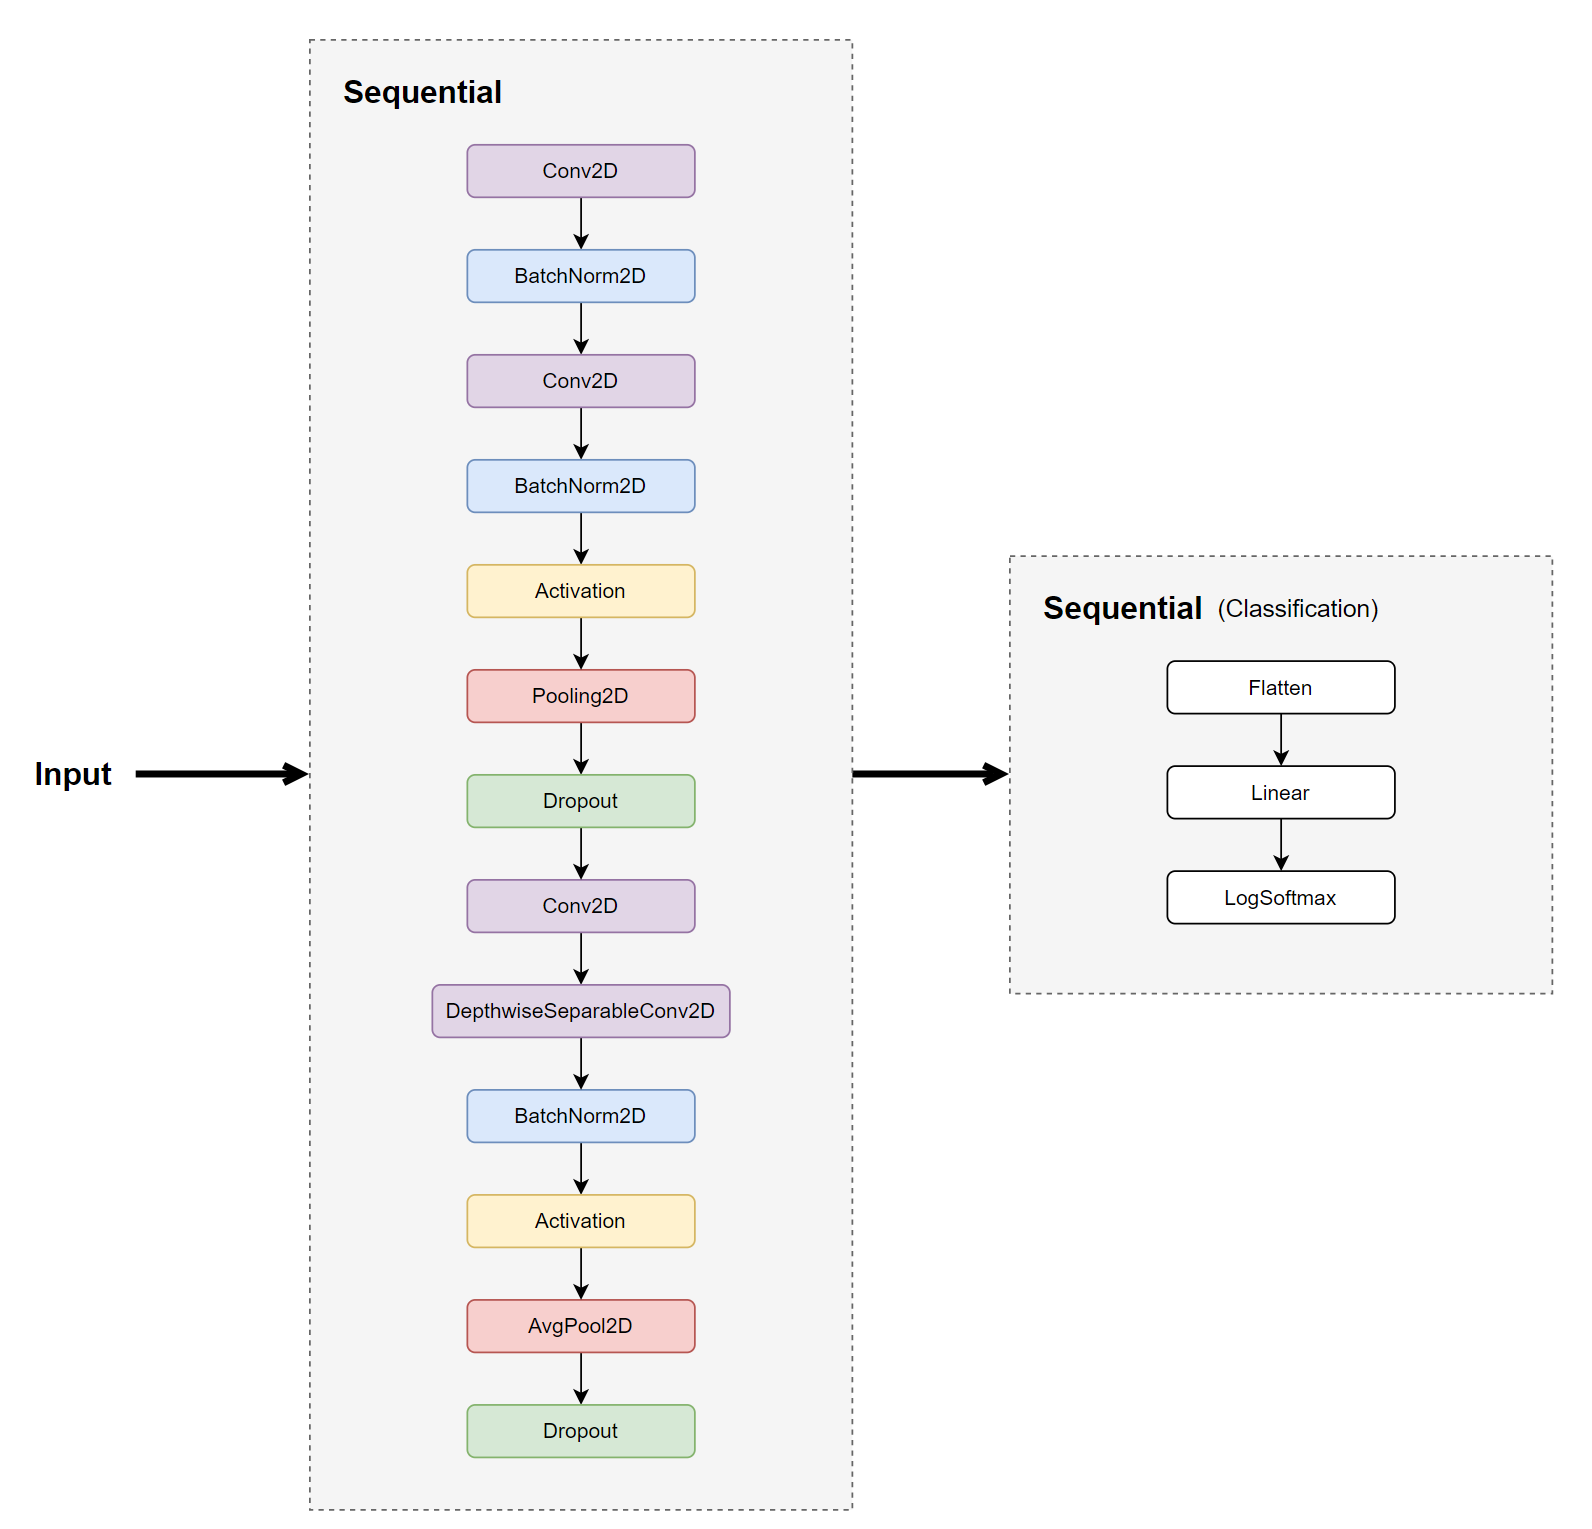|
|:--:|
|Fig.5. CustomModel3 Architecture Diagram|

The models that resemble most to the existing research are most effective as they are simple enough to capture the main trends of the BNCI2014_001 MOABB dataset while also not overfitting due to increased complexity of hidden layer architecture.

Overall the main takeaways were that lower complexity models outperform high complexity ones, and that `BatchNorm2D` provided the best outcome for normalization when compared to other normalization techniques like `GroupNorm` when used with `Conv2D` layers. Additionally, `DepthwiseSeparableConv2D` could provide more accurate results than `Conv2D` alone, however more testing should be done on this topic as the performance increase was quite negligible (74%, up from 73%).

The main results achieved were an accuracy of 74.5945% ± 0.236% for the best model, `CustomModel3`.

## **Experimental Setup And Results**
This project uses the BNCI2014_001 dataset containing EEG motor imagery data provided by SpeechBrain-MOABB.

This dataset consists of EEG data collected from 9 subjects over the course of 2 days (one session per day)[3]. Each session has 6 runs of 48 trials each, where subjects imagine the movement of one of four options (left hand - class 1, right rand - class 2, both feet - class 3, and tongue - class 4). In total 288 trials per session were recorded [3].

To solve this problem of finding a machine learning model that can accurately translate EEG signals to imagined movements, the data was first separated into multiple sets; the training set, validation set, and the test set. For the experiments, the mode "leave-one-session-out" was selected, which essentially assigns the test set to one of the sessions instead of spliting it to leave an entire participant out as the test set. This test set could then be compared to the labelled data to calculate the model accuracy seeing as it is a supervised learning task.

For each custom model creation, the following steps were incorporated:

1.   Define model and save it to a file
2.   Create and save default hyperparms yaml file (used EEGNet hyperparams file as a template)
3.   Use Orion to search for optimal hyperparams
4.   Train model on one subject using new tuned hyperparams to see if it's worth running entire dataset training on it
5.   If training for one subject looks promising, execute `run_experiments.sh` to run experiment over all 10 subjects in the dataset

Below are these steps in action, with a replication of the original SpeechBrain model to ensure validity of tests:


#### Replication of existing experiments

##### Environment Setup

Mount to Google Drive to save results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Create working directory in drive

In [ ]:
!mkdir '/content/drive/MyDrive/EEG_Project'

Initializing SpeechBrain-MOABB

In [ ]:
%%capture
%cd /content/drive/MyDrive/EEG_Project/
!git clone https://github.com/speechbrain/benchmarks
%cd /content/drive/MyDrive/EEG_Project/benchmarks
!git checkout eeg

%cd /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB
!pip install -r extra-requirements.txt # Install additional dependencies

In [ ]:
%%capture
%cd /content/drive/MyDrive/EEG_Project/
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/drive/MyDrive/EEG_Project/speechbrain/

# Install required dependencies
!pip install -r requirements.txt

# Install in edit mode
!pip install -e .

%cd /content/drive/MyDrive/EEG_Project/

##### Replicate training data for one subject

In [ ]:
%cd /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/

!python train.py hparams/MotorImagery/BNCI2014001/EEGNet.yaml \
--data_folder=eeg_data \
--cached_data_folder=eeg_pickled_data \
--output_folder=results/MotorImagery/BNCI2014001/ \
--target_subject_idx=0 \
--target_session_idx=1 \
--data_iterator_name=leave-one-session-out

##### Replicate training data for all subjects

In [ ]:
%cd /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/
!chmod +x /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/run_experiments.sh

!./run_experiments.sh \
--hparams hparams/MotorImagery/BNCI2014001/EEGNet.yaml \
--data_folder eeg_data \
--output_folder results/MotorImagery/BNCI2014001/EEGNet \
--nsbj 9 \
--nsess 2 \
--nruns 10 \
--train_mode leave-one-session-out \
--device=cuda

Streaming output truncated to the last 5000 lines.
speechbrain.nnet.schedulers - Changing lr from 8.3e-06 to 7e-06
speechbrain.utils.train_logger - epoch: 38, lr: 9.73e-06 - train loss: 1.75e-01 - valid loss: 9.84e-01, valid f1: 5.62e-01, valid acc: 5.71e-01, valid cm: [[14  0  0  0]
 [ 6  7  1  0]
 [ 8  1  4  1]
 [ 6  1  0  7]]
speechbrain.utils.epoch_loop - Going into epoch 39
speechbrain.nnet.schedulers - Changing lr from 1.3e-05 to 1.4e-05
speechbrain.utils.train_logger - epoch: 39, lr: 1.11e-05 - train loss: 1.67e-01 - valid loss: 9.35e-01, valid f1: 5.80e-01, valid acc: 5.89e-01, valid cm: [[14  0  0  0]
 [ 5  8  1  0]
 [ 8  1  4  1]
 [ 6  1  0  7]]
speechbrain.utils.epoch_loop - Going into epoch 40
speechbrain.nnet.schedulers - Changing lr from 3.3e-05 to 3.5e-05
speechbrain.utils.train_logger - epoch: 40, lr: 3.20e-05 - train loss: 1.57e-01 - valid loss: 8.84e-01, valid f1: 5.97e-01, valid acc: 6.07e-01, valid cm: [[14  0  0  0]
 [ 4  9  1  0]
 [ 8  1  4  1]
 [ 6  1  0  7]]
spe

Results
```
Final Results (Performance Aggregation)

---- leave-one-session-out ----

0train acc [0.747700 0.731100 0.737300 0.735000 0.728400 0.731900 0.731900 0.737700 0.723000 0.739200] avg: 0.734320 ± 0.006394
1test acc [0.726500 0.720700 0.704100 0.726500 0.716800 0.732300 0.720300 0.719900 0.730300 0.725700] avg: 0.722310 ± 0.007646


Aggregated results

acc [0.737076 0.725887 0.720679 0.730710 0.722608 0.732060 0.726080 0.728781 0.726659 0.732446] avg: 0.728299 ± 0.004672
[{'name': 'objective', 'type': 'objective', 'value': 0.27170138888888884}]
```

### Custom Model 1

#### Define new custom model

In [ ]:
%%writefile benchmarks/benchmarks/MOABB/models/CustomModel1.py
import torch
import speechbrain as sb


class CustomModel1(torch.nn.Module):
    """CustomModel1.

    Arguments
    ---------
    input_shape: tuple
        The shape of the input.
    cnn_temporal_kernels: int
        Number of kernels in the 2d temporal convolution.
    cnn_temporal_kernelsize: tuple
        Kernel size of the 2d temporal convolution.
    cnn_spatial_depth_multiplier: int
        Depth multiplier of the 2d spatial depthwise convolution.
    cnn_spatial_max_norm: float
        Kernel max norm of the 2d spatial depthwise convolution.
    cnn_spatial_pool: tuple
        Pool size and stride after the 2d spatial depthwise convolution.
    cnn_septemporal_depth_multiplier: int
        Depth multiplier of the 2d temporal separable convolution.
    cnn_septemporal_kernelsize: tuple
        Kernel size of the 2d temporal separable convolution.
    cnn_septemporal_pool: tuple
        Pool size and stride after the 2d temporal separable convolution.
    cnn_pool_type: string
        Pooling type.
    dropout: float
        Dropout probability.
    dense_max_norm: float
        Weight max norm of the fully-connected layer.
    dense_n_neurons: int
        Number of output neurons.
    activation_type: str
        Activation function of the hidden layers.

    Example
    -------
    #>>> inp_tensor = torch.rand([1, 200, 32, 1])
    #>>> model = EEGNet(input_shape=inp_tensor.shape)
    #>>> output = model(inp_tensor)
    #>>> output.shape
    #torch.Size([1,4])
    """

    def __init__(
        self,
        input_shape=None,  # (1, T, C, 1)
        cnn_temporal_kernels=8,
        cnn_temporal_kernelsize=(33, 1),
        cnn_spatial_depth_multiplier=2,
        cnn_spatial_max_norm=1.0,
        cnn_spatial_pool=(4, 1),
        cnn_septemporal_depth_multiplier=1,
        cnn_septemporal_point_kernels=None,
        cnn_septemporal_kernelsize=(17, 1),
        cnn_septemporal_pool=(8, 1),
        cnn_pool_type="avg",
        dropout=0.5,
        dense_max_norm=0.25,
        dense_n_neurons=4,
        activation_type="elu",
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        if activation_type == "gelu":
            activation = torch.nn.GELU()
        elif activation_type == "elu":
            activation = torch.nn.ELU()
        elif activation_type == "relu":
            activation = torch.nn.ReLU()
        elif activation_type == "leaky_relu":
            activation = torch.nn.LeakyReLU()
        elif activation_type == "prelu":
            activation = torch.nn.PReLU()
        else:
            raise ValueError("Wrong hidden activation function")
        self.default_sf = 128  # sampling rate of the original publication (Hz)
        # T = input_shape[1]
        C = input_shape[2]

        # CONVOLUTIONAL MODULE
        self.conv_module = torch.nn.Sequential()
        # Temporal convolution
        self.conv_module.add_module(
            "conv_0",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels,
                kernel_size=cnn_temporal_kernelsize,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_0",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels, momentum=0.01, affine=True,
            ),
        )
        # Spatial depthwise convolution
        cnn_spatial_kernels = (
            cnn_spatial_depth_multiplier * cnn_temporal_kernels
        )
        self.conv_module.add_module(
            "conv_1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels,
                out_channels=cnn_spatial_kernels,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels,
                padding="valid",
                bias=False,
                max_norm=cnn_spatial_max_norm,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_spatial_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("act_1", activation)
        self.conv_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_spatial_pool,
                stride=cnn_spatial_pool,
                pool_axis=[1, 2],
            ),
        )
        self.conv_module.add_module("dropout_1", torch.nn.Dropout(p=dropout))

        # Temporal separable convolution
        cnn_septemporal_kernels = (
            cnn_spatial_kernels * cnn_septemporal_depth_multiplier
        )
        self.conv_module.add_module(
            "conv_2",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_spatial_kernels,
                out_channels=cnn_septemporal_kernels,
                kernel_size=cnn_septemporal_kernelsize,
                groups=cnn_spatial_kernels,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        if cnn_septemporal_point_kernels is None:
            cnn_septemporal_point_kernels = cnn_septemporal_kernels

        self.conv_module.add_module(
            "conv_3",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_septemporal_kernels,
                out_channels=cnn_septemporal_point_kernels,
                kernel_size=(1, 1),
                padding="valid",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_3",
            sb.nnet.normalization.GroupNorm(
                input_size=cnn_septemporal_point_kernels,
                num_groups=cnn_septemporal_point_kernels
            ),
        )
        self.conv_module.add_module("act_3", activation)
        self.conv_module.add_module(
            "pool_3",
            torch.nn.AdaptiveAvgPool2d(1),
        )

        self.conv_module.add_module("dropout_3", torch.nn.Dropout(p=dropout))

        # Shape of intermediate feature maps
        out = self.conv_module(
            torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))
        )
        dense_input_size = self._num_flat_features(out)
        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size,
                n_neurons=dense_n_neurons,
                max_norm=dense_max_norm,
            ),
        )
        self.dense_module.add_module("act_out", sb.nnet.activations.GumbelSoftmax(tau=0.8, hard=True))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = self.conv_module(x)
        x = self.dense_module(x)
        return x


#### Define the hyperparmeter YAML file

In [ ]:
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml

custom_hyperparams = """
seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.13 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 46.0 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 10 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 862 # @orion_step1: --number_of_epochs~"uniform(250, 1000, discrete=True)"
lr: 0.0001 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 4 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.01742 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 19.1 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 61 # @orion_step1: --cnn_temporal_kernels~"uniform(4, 64,discrete=True)"
cnn_temporal_kernelsize: 51 # @orion_step1: --cnn_temporal_kernelsize~"uniform(24, 62,discrete=True)"
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 4 # @orion_step1: --cnn_spatial_depth_multiplier~"uniform(1, 4,discrete=True)"
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
cnn_septemporal_depth_multiplier: 1  # depth multiplier for the separable temporal conv. layer
cnn_septemporal_point_kernels_ratio_: 7 # @orion_step1: --cnn_septemporal_point_kernels_ratio_~"uniform(0, 8, discrete=True)"
cnn_septemporal_point_kernels_ratio: !ref <cnn_septemporal_point_kernels_ratio_> / 4
## number of temporal filters in the separable temporal conv. layer
cnn_septemporal_point_kernels_: !ref <cnn_temporal_kernels> * <cnn_spatial_depth_multiplier> * <cnn_septemporal_depth_multiplier>
cnn_septemporal_point_kernels: !apply:math.ceil
    - !ref <cnn_septemporal_point_kernels_ratio> * <cnn_septemporal_point_kernels_> + 1
cnn_septemporal_kernelsize_: 15 # @orion_step1: --cnn_septemporal_kernelsize_~"uniform(3, 24,discrete=True)"
max_cnn_spatial_pool: 4
cnn_septemporal_kernelsize: !apply:round
    - !ref <cnn_septemporal_kernelsize_> * <max_cnn_spatial_pool> / <cnn_spatial_pool>
cnn_septemporal_pool: 7 # @orion_step1: --cnn_septemporal_pool~"uniform(1, 8,discrete=True)"
cnn_pool_type: 'avg'
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.008464 # @orion_step1: --dropout~"uniform(0.0, 0.5)"
activation_type: 'elu'

model: !new:models.CustomModel1.CustomModel1
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_max_norm: !ref <cnn_spatial_max_norm>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    cnn_septemporal_depth_multiplier: !ref <cnn_septemporal_depth_multiplier>
    cnn_septemporal_point_kernels: !ref <cnn_septemporal_point_kernels>
    cnn_septemporal_kernelsize: [!ref <cnn_septemporal_kernelsize>, 1]
    cnn_septemporal_pool: [!ref <cnn_septemporal_pool>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    activation_type: !ref <activation_type>
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>
"""

Save the `yaml` file on disk

In [ ]:
f = open('benchmarks/benchmarks/MOABB/hparams/MotorImagery/BNCI2014001/CustomModel1.yaml', 'w')
f.write(custom_hyperparams)
f.close()

#### Optimizing hyperparams with Orion

In [ ]:
%cd /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/
!chmod +x /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/run_hparam_optimization.sh
!chmod +x /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/run_experiments.sh

!./run_hparam_optimization.sh \
    --hparams hparams/MotorImagery/BNCI2014001/CustomModel1.yaml \
    --data_folder eeg_data \
    --cached_data_folder eeg_pickled_data \
    --output_folder results/MotorImagery/BNCI2014001/CustomModel1/hopt \
    --nsbj 9 --nsess 2 --nruns 1 --train_mode leave-one-session-out \
    --exp_name 'CustomModel1_hopt' \
    --nsbj_hpsearch 1 --nsess_hpsearch 1 \
    --nruns_eval 1 \
    --eval_metric acc \
    --exp_max_trials 50 \
    --device=cuda

Streaming output truncated to the last 5000 lines.
speechbrain.utils.train_logger - epoch: 586, lr: 9.72e-04 - train loss: -9.28e-01 - valid loss: -5.83e-01, valid f1: 5.91e-01, valid acc: 5.89e-01, valid cm: [[9 0 1 4]
 [1 9 2 2]
 [2 2 8 2]
 [4 2 1 7]]
speechbrain.utils.epoch_loop - Going into epoch 587
speechbrain.nnet.schedulers - Changing lr from 0.0022 to 0.0024
speechbrain.utils.train_logger - epoch: 587, lr: 2.08e-03 - train loss: -9.26e-01 - valid loss: -5.47e-01, valid f1: 5.63e-01, valid acc: 5.54e-01, valid cm: [[8 0 0 6]
 [1 8 3 2]
 [1 1 8 4]
 [4 2 1 7]]
speechbrain.utils.epoch_loop - Going into epoch 588
speechbrain.nnet.schedulers - Changing lr from 0.0033 to 0.0035
speechbrain.utils.train_logger - epoch: 588, lr: 3.19e-03 - train loss: -9.00e-01 - valid loss: -5.73e-01, valid f1: 5.88e-01, valid acc: 5.89e-01, valid cm: [[ 7  0  3  4]
 [ 0 11  2  1]
 [ 1  1  9  3]
 [ 4  2  2  6]]
speechbrain.utils.epoch_loop - Going into epoch 589
speechbrain.nnet.schedulers - Changing l

Results
```
Final Results (Performance Aggregation)


---- leave-one-session-out ----

0train acc [0.537000] avg: 0.537000 ± 0.000000
1test acc [0.549800] avg: 0.549800 ± 0.000000


Aggregated results

acc [0.543403] avg: 0.543403 ± 0.000000
[{'name': 'objective', 'type': 'objective', 'value': 0.4565972222222223}]
The test performance with best hparams is available at  results/MotorImagery/BNCI2014001/CustomModel1/hopt/best
```

#### Update hyperparms to best ones from Orion search

In [ ]:
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml

tuned_hyperparams = """
seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.12
fmax: 23.8
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 1.0
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 9
number_of_epochs: 696
lr: 0.005
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 5
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 6
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.3708
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 8.2
snr_white_delta: 14.6
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 8
cnn_temporal_kernelsize: 28
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 4
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
cnn_septemporal_depth_multiplier: 1  # depth multiplier for the separable temporal conv. layer
cnn_septemporal_point_kernels_ratio_: 0
cnn_septemporal_point_kernels_ratio: !ref <cnn_septemporal_point_kernels_ratio_> / 4
## number of temporal filters in the separable temporal conv. layer
cnn_septemporal_point_kernels_: !ref <cnn_temporal_kernels> * <cnn_spatial_depth_multiplier> * <cnn_septemporal_depth_multiplier>
cnn_septemporal_point_kernels: !apply:math.ceil
    - !ref <cnn_septemporal_point_kernels_ratio> * <cnn_septemporal_point_kernels_> + 1
cnn_septemporal_kernelsize_: 23
max_cnn_spatial_pool: 4
cnn_septemporal_kernelsize: !apply:round
    - !ref <cnn_septemporal_kernelsize_> * <max_cnn_spatial_pool> / <cnn_spatial_pool>
cnn_septemporal_pool: 3
cnn_pool_type: 'avg'
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.0004677
activation_type: 'elu'

model: !new:models.CustomModel1.CustomModel1
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_max_norm: !ref <cnn_spatial_max_norm>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    cnn_septemporal_depth_multiplier: !ref <cnn_septemporal_depth_multiplier>
    cnn_septemporal_point_kernels: !ref <cnn_septemporal_point_kernels>
    cnn_septemporal_kernelsize: [!ref <cnn_septemporal_kernelsize>, 1]
    cnn_septemporal_pool: [!ref <cnn_septemporal_pool>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    activation_type: !ref <activation_type>
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>

"""
f = open('/content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/hparams/MotorImagery/BNCI2014001/CustomModel1_best.yaml', 'w')
f.write(tuned_hyperparams)
f.close()

#### Train model for one subject.



In [ ]:
%cd /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/

!python train.py hparams/MotorImagery/BNCI2014001/CustomModel1_best.yaml \
--data_folder=eeg_data \
--cached_data_folder=eeg_pickled_data \
--output_folder=results/MotorImagery/BNCI2014001/CustomModel1_best \
--target_subject_idx=0 \
--target_session_idx=1 \
--data_iterator_name=leave-one-session-out

/content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
2024-04-19 17:33:49.600600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 17:33:49.600649: E external/local_xla/xla/stream_executor/

There is no need to train for all subjects as the accuracy is already too low in one subject (51.8%) to justify computational effort required to run experiment on all subjects.

### Custom Model 2

#### Create the model

In [ ]:
%%writefile /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/models/CustomModel2.py
import torch
import speechbrain as sb


class CustomModel2(torch.nn.Module):
    """CustomModel2.

    Arguments
    ---------
    input_shape: tuple
        The shape of the input.
    cnn_temporal_kernels: int
        Number of kernels in the 2d temporal convolution.
    cnn_temporal_kernelsize: tuple
        Kernel size of the 2d temporal convolution.
    cnn_spatial_depth_multiplier: int
        Depth multiplier of the 2d spatial depthwise convolution.
    cnn_spatial_max_norm: float
        Kernel max norm of the 2d spatial depthwise convolution.
    cnn_spatial_pool: tuple
        Pool size and stride after the 2d spatial depthwise convolution.
    cnn_septemporal_depth_multiplier: int
        Depth multiplier of the 2d temporal separable convolution.
    cnn_septemporal_kernelsize: tuple
        Kernel size of the 2d temporal separable convolution.
    cnn_septemporal_pool: tuple
        Pool size and stride after the 2d temporal separable convolution.
    cnn_pool_type: string
        Pooling type.
    dropout: float
        Dropout probability.
    dense_max_norm: float
        Weight max norm of the fully-connected layer.
    dense_n_neurons: int
        Number of output neurons.
    activation_type: str
        Activation function of the hidden layers.

    Example
    -------
    #>>> inp_tensor = torch.rand([1, 200, 32, 1])
    #>>> model = EEGNet(input_shape=inp_tensor.shape)
    #>>> output = model(inp_tensor)
    #>>> output.shape
    #torch.Size([1,4])
    """

    def __init__(
            self,
            input_shape=None,  # (1, T, C, 1)
            cnn_temporal_kernels=8,
            cnn_temporal_kernelsize=(33, 1),
            cnn_spatial_depth_multiplier=2,
            cnn_spatial_max_norm=1.0,
            cnn_spatial_pool=(4, 1),
            cnn_septemporal_depth_multiplier=1,
            cnn_septemporal_point_kernels=None,
            cnn_septemporal_kernelsize=(17, 1),
            cnn_septemporal_pool=(8, 1),
            cnn_pool_type="avg",
            dropout=0.5,
            dense_max_norm=0.25,
            dense_n_neurons=4,
            activation_type="elu",
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        if activation_type == "gelu":
            activation = torch.nn.GELU()
        elif activation_type == "elu":
            activation = torch.nn.ELU()
        elif activation_type == "relu":
            activation = torch.nn.ReLU()
        elif activation_type == "leaky_relu":
            activation = torch.nn.LeakyReLU()
        elif activation_type == "prelu":
            activation = torch.nn.PReLU()
        else:
            raise ValueError("Wrong hidden activation function")
        self.default_sf = 128  # sampling rate of the original publication (Hz)
        T = input_shape[1]
        C = input_shape[2]

        # CONVOLUTIONAL MODULE
        self.conv_module = torch.nn.Sequential()
        # Temporal convolution
        self.conv_module.add_module(
            "conv_0",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels,
                kernel_size=cnn_temporal_kernelsize,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_0",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels, momentum=0.01, affine=True,
            ),
        )
        # Spatial depthwise convolution
        cnn_spatial_kernels = (
                cnn_spatial_depth_multiplier * cnn_temporal_kernels
        )
        self.conv_module.add_module(
            "conv_1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels,
                out_channels=cnn_spatial_kernels,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels,
                padding="valid",
                bias=False,
                max_norm=cnn_spatial_max_norm,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_spatial_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("act_1", activation)
        self.conv_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_spatial_pool,
                stride=cnn_spatial_pool,
                pool_axis=[1, 2],
            ),
        )
        self.conv_module.add_module("dropout_1", torch.nn.Dropout(p=dropout))

        # Temporal separable convolution
        cnn_septemporal_kernels = (
                cnn_spatial_kernels * cnn_septemporal_depth_multiplier
        )
        self.conv_module.add_module(
            "conv_2",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_spatial_kernels,
                out_channels=cnn_septemporal_kernels,
                kernel_size=cnn_septemporal_kernelsize,
                groups=cnn_spatial_kernels,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        if cnn_septemporal_point_kernels is None:
            cnn_septemporal_point_kernels = cnn_septemporal_kernels

        # New Depthwise Separable 2D CNN
        self.conv_module.add_module(
            "conv_3",
            sb.nnet.CNN.DepthwiseSeparableConv2d(
                input_shape=(1, cnn_spatial_kernels, 1, cnn_septemporal_kernels),
                out_channels=cnn_septemporal_point_kernels,
                kernel_size=(1, 1),
                padding="valid",
                bias=False
            ),
        )

        self.conv_module.add_module(
            "bnorm_3",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_septemporal_point_kernels, momentum=0.01, affine=True,
            ),
        )

        self.conv_module.add_module("act_3", activation)
        self.conv_module.add_module(
            "pool_3",
            sb.nnet.pooling.StatisticsPooling(),
        )

        self.conv_module.add_module("dropout_3", torch.nn.Dropout(p=dropout))

        # Shape of intermediate feature maps
        out = self.conv_module(
            torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))
        )
        dense_input_size = self._num_flat_features(out)
        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size,
                n_neurons=dense_n_neurons,
                max_norm=dense_max_norm,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = self.conv_module(x)
        x = self.dense_module(x)
        return x



#### Define the hyperparameters yaml

In [ ]:
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml

custom_hyperparams = """
seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.13 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 46.0 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 10 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 862 # @orion_step1: --number_of_epochs~"uniform(250, 1000, discrete=True)"
lr: 0.0001 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 4 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.01742 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 19.1 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 61 # @orion_step1: --cnn_temporal_kernels~"uniform(4, 64,discrete=True)"
cnn_temporal_kernelsize: 51 # @orion_step1: --cnn_temporal_kernelsize~"uniform(24, 62,discrete=True)"
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 4 # @orion_step1: --cnn_spatial_depth_multiplier~"uniform(1, 4,discrete=True)"
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
cnn_septemporal_depth_multiplier: 1  # depth multiplier for the separable temporal conv. layer
cnn_septemporal_point_kernels_ratio_: 7 # @orion_step1: --cnn_septemporal_point_kernels_ratio_~"uniform(0, 8, discrete=True)"
cnn_septemporal_point_kernels_ratio: !ref <cnn_septemporal_point_kernels_ratio_> / 4
## number of temporal filters in the separable temporal conv. layer
cnn_septemporal_point_kernels_: !ref <cnn_temporal_kernels> * <cnn_spatial_depth_multiplier> * <cnn_septemporal_depth_multiplier>
cnn_septemporal_point_kernels: !apply:math.ceil
    - !ref <cnn_septemporal_point_kernels_ratio> * <cnn_septemporal_point_kernels_> + 1
cnn_septemporal_kernelsize_: 15 # @orion_step1: --cnn_septemporal_kernelsize_~"uniform(3, 24,discrete=True)"
max_cnn_spatial_pool: 4
cnn_septemporal_kernelsize: !apply:round
    - !ref <cnn_septemporal_kernelsize_> * <max_cnn_spatial_pool> / <cnn_spatial_pool>
cnn_septemporal_pool: 7 # @orion_step1: --cnn_septemporal_pool~"uniform(1, 8,discrete=True)"
cnn_pool_type: 'avg'
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.008464 # @orion_step1: --dropout~"uniform(0.0, 0.5)"
activation_type: 'elu'

model: !new:models.CustomModel2.CustomModel2
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_max_norm: !ref <cnn_spatial_max_norm>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    cnn_septemporal_depth_multiplier: !ref <cnn_septemporal_depth_multiplier>
    cnn_septemporal_point_kernels: !ref <cnn_septemporal_point_kernels>
    cnn_septemporal_kernelsize: [!ref <cnn_septemporal_kernelsize>, 1]
    cnn_septemporal_pool: [!ref <cnn_septemporal_pool>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    activation_type: !ref <activation_type>
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>
"""

In [ ]:
f = open('/content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/hparams/MotorImagery/BNCI2014001/CustomModel2.yaml', 'w')
f.write(custom_hyperparams)
f.close()

#### Optimizing hyperparams with Orion

In [ ]:
%cd /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/
!chmod +x /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/run_hparam_optimization.sh
!chmod +x /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/run_experiments.sh

!./run_hparam_optimization.sh \
    --hparams hparams/MotorImagery/BNCI2014001/CustomModel2.yaml \
    --data_folder eeg_data \
    --cached_data_folder eeg_pickled_data \
    --output_folder results/MotorImagery/BNCI2014001/CustomModel2/hopt \
    --nsbj 9 --nsess 2 --nruns 1 --train_mode leave-one-session-out \
    --exp_name 'CustomModel2_hopt' \
    --nsbj_hpsearch 1 --nsess_hpsearch 1 \
    --nruns_eval 1 \
    --eval_metric acc \
    --exp_max_trials 50 \
    --device=cuda

Streaming output truncated to the last 5000 lines.
speechbrain.utils.epoch_loop - Going into epoch 149
speechbrain.nnet.schedulers - Changing lr from 0.00096 to 0.00094
speechbrain.utils.train_logger - epoch: 149, lr: 9.72e-04 - train loss: 8.23e-01 - valid loss: 8.38e-01, valid f1: 7.47e-01, valid acc: 7.50e-01, valid cm: [[12  1  1  0]
 [ 0 12  1  1]
 [ 1  3  8  2]
 [ 1  1  2 10]]
speechbrain.utils.epoch_loop - Going into epoch 150
speechbrain.nnet.schedulers - Changing lr from 0.00075 to 0.00074
speechbrain.utils.train_logger - epoch: 150, lr: 7.64e-04 - train loss: 8.49e-01 - valid loss: 8.23e-01, valid f1: 7.64e-01, valid acc: 7.68e-01, valid cm: [[13  0  1  0]
 [ 1 11  1  1]
 [ 1  2  8  3]
 [ 1  0  2 11]]
speechbrain.utils.epoch_loop - Going into epoch 151
speechbrain.nnet.schedulers - Changing lr from 0.00054 to 0.00053
speechbrain.utils.train_logger - epoch: 151, lr: 5.56e-04 - train loss: 8.41e-01 - valid loss: 8.37e-01, valid f1: 7.83e-01, valid acc: 7.86e-01, valid cm: [[13 

Results
```
Final Results (Performance Aggregation)


---- leave-one-session-out ----

0train acc [0.675500] avg: 0.675500 ± 0.000000
1test acc [0.704500] avg: 0.704500 ± 0.000000


Aggregated results

acc [0.690008] avg: 0.690008 ± 0.000000
[{'name': 'objective', 'type': 'objective', 'value': 0.3099922839506173}]
The test performance with best hparams is available at  results/MotorImagery/BNCI2014001/CustomModel2/hopt/best
```

#### Update hyperparms to best ones from Orion search

In [ ]:
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml

tuned_hyperparams = """
seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.21
fmax: 39.4
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 3.7
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 12
number_of_epochs: 972
lr: 0.001
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 4
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 4
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.01407
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 12.0
snr_white_delta: 5.02
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 27
cnn_temporal_kernelsize: 40
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 1
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
cnn_septemporal_depth_multiplier: 1  # depth multiplier for the separable temporal conv. layer
cnn_septemporal_point_kernels_ratio_: 6
cnn_septemporal_point_kernels_ratio: !ref <cnn_septemporal_point_kernels_ratio_> / 4
## number of temporal filters in the separable temporal conv. layer
cnn_septemporal_point_kernels_: !ref <cnn_temporal_kernels> * <cnn_spatial_depth_multiplier> * <cnn_septemporal_depth_multiplier>
cnn_septemporal_point_kernels: !apply:math.ceil
    - !ref <cnn_septemporal_point_kernels_ratio> * <cnn_septemporal_point_kernels_> + 1
cnn_septemporal_kernelsize_: 17
max_cnn_spatial_pool: 4
cnn_septemporal_kernelsize: !apply:round
    - !ref <cnn_septemporal_kernelsize_> * <max_cnn_spatial_pool> / <cnn_spatial_pool>
cnn_septemporal_pool: 8
cnn_pool_type: 'avg'
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.3871
activation_type: 'elu'

model: !new:models.CustomModel2.CustomModel2
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_max_norm: !ref <cnn_spatial_max_norm>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    cnn_septemporal_depth_multiplier: !ref <cnn_septemporal_depth_multiplier>
    cnn_septemporal_point_kernels: !ref <cnn_septemporal_point_kernels>
    cnn_septemporal_kernelsize: [!ref <cnn_septemporal_kernelsize>, 1]
    cnn_septemporal_pool: [!ref <cnn_septemporal_pool>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    activation_type: !ref <activation_type>
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>

"""
f = open('/content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/hparams/MotorImagery/BNCI2014001/CustomModel2_best.yaml', 'w')
f.write(tuned_hyperparams)
f.close()

#### Train custom model for one subject

In [ ]:
%cd benchmarks/benchmarks/MOABB/

!python train.py hparams/MotorImagery/BNCI2014001/CustomModel2_best.yaml \
--data_folder=eeg_data \
--cached_data_folder=eeg_pickled_data \
--output_folder=results/MotorImagery/BNCI2014001/CustomModel2 \
--target_subject_idx=0 \
--target_session_idx=1 \
--data_iterator_name=leave-one-session-out \
--device=cuda

Streaming output truncated to the last 5000 lines.
 [ 3 11  0  0]
 [ 2  0  8  4]
 [ 0  0  2 12]]
speechbrain.utils.epoch_loop - Going into epoch 146
speechbrain.nnet.schedulers - Changing lr from 0.00042 to 0.00043
speechbrain.utils.train_logger - epoch: 146, lr: 4.03e-04 - train loss: 7.54e-01 - valid loss: 7.68e-01, valid f1: 7.44e-01, valid acc: 7.50e-01, valid cm: [[ 7  6  0  1]
 [ 2 12  0  0]
 [ 1  0 12  1]
 [ 0  0  3 11]]
speechbrain.utils.epoch_loop - Going into epoch 147
speechbrain.nnet.schedulers - Changing lr from 0.00063 to 0.00064
speechbrain.utils.train_logger - epoch: 147, lr: 6.11e-04 - train loss: 8.15e-01 - valid loss: 7.75e-01, valid f1: 7.23e-01, valid acc: 7.32e-01, valid cm: [[ 6  7  0  1]
 [ 2 12  0  0]
 [ 1  0 12  1]
 [ 0  0  3 11]]
speechbrain.utils.epoch_loop - Going into epoch 148
speechbrain.nnet.schedulers - Changing lr from 0.00083 to 0.00085
speechbrain.utils.train_logger - epoch: 148, lr: 8.19e-04 - train loss: 8.03e-01 - valid loss: 8.09e-01, valid f1: 

There is no need to train for all subjects as the accuracy is already too low in one subject in hyperparameter tuning to justify computational effort required to run experiment on all subjects.

### Custom Model 3

#### Create model

In [ ]:
%%writefile /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/models/CustomModel3.py
import torch
import speechbrain as sb


class CustomModel3(torch.nn.Module):
    """CustomModel3.

    Arguments
    ---------
    input_shape: tuple
        The shape of the input.
    cnn_temporal_kernels: int
        Number of kernels in the 2d temporal convolution.
    cnn_temporal_kernelsize: tuple
        Kernel size of the 2d temporal convolution.
    cnn_spatial_depth_multiplier: int
        Depth multiplier of the 2d spatial depthwise convolution.
    cnn_spatial_max_norm: float
        Kernel max norm of the 2d spatial depthwise convolution.
    cnn_spatial_pool: tuple
        Pool size and stride after the 2d spatial depthwise convolution.
    cnn_septemporal_depth_multiplier: int
        Depth multiplier of the 2d temporal separable convolution.
    cnn_septemporal_kernelsize: tuple
        Kernel size of the 2d temporal separable convolution.
    cnn_septemporal_pool: tuple
        Pool size and stride after the 2d temporal separable convolution.
    cnn_pool_type: string
        Pooling type.
    dropout: float
        Dropout probability.
    dense_max_norm: float
        Weight max norm of the fully-connected layer.
    dense_n_neurons: int
        Number of output neurons.
    activation_type: str
        Activation function of the hidden layers.

    Example
    -------
    #>>> inp_tensor = torch.rand([1, 200, 32, 1])
    #>>> model = EEGNet(input_shape=inp_tensor.shape)
    #>>> output = model(inp_tensor)
    #>>> output.shape
    #torch.Size([1,4])
    """

    def __init__(
            self,
            input_shape=None,  # (1, T, C, 1)
            cnn_temporal_kernels=8,
            cnn_temporal_kernelsize=(33, 1),
            cnn_spatial_depth_multiplier=2,
            cnn_spatial_max_norm=1.0,
            cnn_spatial_pool=(4, 1),
            cnn_septemporal_depth_multiplier=1,
            cnn_septemporal_point_kernels=None,
            cnn_septemporal_kernelsize=(17, 1),
            cnn_septemporal_pool=(8, 1),
            cnn_pool_type="avg",
            dropout=0.5,
            dense_max_norm=0.25,
            dense_n_neurons=4,
            activation_type="elu",
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        if activation_type == "gelu":
            activation = torch.nn.GELU()
        elif activation_type == "elu":
            activation = torch.nn.ELU()
        elif activation_type == "relu":
            activation = torch.nn.ReLU()
        elif activation_type == "leaky_relu":
            activation = torch.nn.LeakyReLU()
        elif activation_type == "prelu":
            activation = torch.nn.PReLU()
        else:
            raise ValueError("Wrong hidden activation function")
        self.default_sf = 128  # sampling rate of the original publication (Hz)
        T = input_shape[1]
        C = input_shape[2]

        # CONVOLUTIONAL MODULE
        self.conv_module = torch.nn.Sequential()
        # Temporal convolution
        self.conv_module.add_module(
            "conv_0",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels,
                kernel_size=cnn_temporal_kernelsize,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_0",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels, momentum=0.01, affine=True,
            ),
        )
        # Spatial depthwise convolution
        cnn_spatial_kernels = (
                cnn_spatial_depth_multiplier * cnn_temporal_kernels
        )
        self.conv_module.add_module(
            "conv_1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels,
                out_channels=cnn_spatial_kernels,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels,
                padding="valid",
                bias=False,
                max_norm=cnn_spatial_max_norm,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_spatial_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("act_1", activation)
        self.conv_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_spatial_pool,
                stride=cnn_spatial_pool,
                pool_axis=[1, 2],
            ),
        )
        self.conv_module.add_module("dropout_1", torch.nn.Dropout(p=dropout))

        # Temporal separable convolution
        cnn_septemporal_kernels = (
                cnn_spatial_kernels * cnn_septemporal_depth_multiplier
        )
        self.conv_module.add_module(
            "conv_2",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_spatial_kernels,
                out_channels=cnn_septemporal_kernels,
                kernel_size=cnn_septemporal_kernelsize,
                groups=cnn_spatial_kernels,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        if cnn_septemporal_point_kernels is None:
            cnn_septemporal_point_kernels = cnn_septemporal_kernels

        # New Depthwise Separable 2D CNN
        self.conv_module.add_module(
            "conv_3",
            sb.nnet.CNN.DepthwiseSeparableConv2d(
                input_shape=(1, cnn_spatial_kernels, 1, cnn_septemporal_kernels),
                out_channels=cnn_septemporal_point_kernels,
                kernel_size=(1, 1),
                padding="valid",
                bias=False,
            ),
        )

        self.conv_module.add_module(
            "bnorm_3",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_septemporal_point_kernels, momentum=0.1, affine=True,
            ),
        )

        self.conv_module.add_module("act_3", activation)
        self.conv_module.add_module(
            "pool_3",
            torch.nn.AvgPool2d(
                kernel_size=(1, 1)
            ),
        )

        self.conv_module.add_module("dropout_3", torch.nn.Dropout(p=dropout))

        # Shape of intermediate feature maps
        out = self.conv_module(
            torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))
        )
        dense_input_size = self._num_flat_features(out)
        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size,
                n_neurons=dense_n_neurons,
                max_norm=dense_max_norm,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = self.conv_module(x)
        x = self.dense_module(x)
        return x

#### Defining unoptimized hyperparams yaml

In [ ]:
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml

custom_hyperparams = """
seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.13 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 46.0 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 10 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 862 # @orion_step1: --number_of_epochs~"uniform(250, 1000, discrete=True)"
lr: 0.0001 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 4 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.01742 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 19.1 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 61 # @orion_step1: --cnn_temporal_kernels~"uniform(4, 64,discrete=True)"
cnn_temporal_kernelsize: 51 # @orion_step1: --cnn_temporal_kernelsize~"uniform(24, 62,discrete=True)"
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 4 # @orion_step1: --cnn_spatial_depth_multiplier~"uniform(1, 4,discrete=True)"
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
cnn_septemporal_depth_multiplier: 1  # depth multiplier for the separable temporal conv. layer
cnn_septemporal_point_kernels_ratio_: 7 # @orion_step1: --cnn_septemporal_point_kernels_ratio_~"uniform(0, 8, discrete=True)"
cnn_septemporal_point_kernels_ratio: !ref <cnn_septemporal_point_kernels_ratio_> / 4
## number of temporal filters in the separable temporal conv. layer
cnn_septemporal_point_kernels_: !ref <cnn_temporal_kernels> * <cnn_spatial_depth_multiplier> * <cnn_septemporal_depth_multiplier>
cnn_septemporal_point_kernels: !apply:math.ceil
    - !ref <cnn_septemporal_point_kernels_ratio> * <cnn_septemporal_point_kernels_> + 1
cnn_septemporal_kernelsize_: 15 # @orion_step1: --cnn_septemporal_kernelsize_~"uniform(3, 24,discrete=True)"
max_cnn_spatial_pool: 4
cnn_septemporal_kernelsize: !apply:round
    - !ref <cnn_septemporal_kernelsize_> * <max_cnn_spatial_pool> / <cnn_spatial_pool>
cnn_septemporal_pool: 7 # @orion_step1: --cnn_septemporal_pool~"uniform(1, 8,discrete=True)"
cnn_pool_type: 'avg'
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.5 # @orion_step1: --dropout~"uniform(0.0, 0.5)"
activation_type: 'elu'

model: !new:models.CustomModel3.CustomModel3
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_max_norm: !ref <cnn_spatial_max_norm>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    cnn_septemporal_depth_multiplier: !ref <cnn_septemporal_depth_multiplier>
    cnn_septemporal_point_kernels: !ref <cnn_septemporal_point_kernels>
    cnn_septemporal_kernelsize: [!ref <cnn_septemporal_kernelsize>, 1]
    cnn_septemporal_pool: [!ref <cnn_septemporal_pool>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    activation_type: !ref <activation_type>
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>
"""

In [ ]:
f = open('/content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/hparams/MotorImagery/BNCI2014001/CustomModel3.yaml', 'w')
f.write(custom_hyperparams)
f.close()

#### Optimizing hyperparams with Orion

In [ ]:
%cd /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/
!chmod +x /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/run_hparam_optimization.sh
!chmod +x /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/run_experiments.sh

!./run_hparam_optimization.sh \
    --hparams hparams/MotorImagery/BNCI2014001/CustomModel3.yaml \
    --data_folder eeg_data \
    --cached_data_folder eeg_pickled_data \
    --output_folder results/MotorImagery/BNCI2014001/CustomModel3/hopt \
    --nsbj 9 --nsess 2 --nruns 1 --train_mode leave-one-session-out \
    --exp_name 'CustomModel3_hopt' \
    --nsbj_hpsearch 1 --nsess_hpsearch 1 \
    --nruns_eval 1 \
    --eval_metric acc \
    --exp_max_trials 50 \
    --device=cuda

Streaming output truncated to the last 5000 lines.
Validation indices: [3, 24, 44, 63, 89, 110, 130, 148, 170, 200, 214, 240, 264, 285, 1, 26, 42, 77, 88, 106, 135, 157, 177, 197, 212, 248, 261, 286, 6, 20, 41, 73, 83, 122, 129, 163, 179, 198, 228, 242, 254, 287, 0, 15, 39, 58, 72, 104, 128, 150, 160, 195, 220, 247, 267, 284]
Sampling channels: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2']
Sampling channels: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2']
Sampling channels: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2']
BNCI2014001 has been renamed to BNCI2014_001. BNCI2014001 will be removed in version 1.1.
The dataset class name 'BNCI2014001' must be an abbreviation of its code 'BNCI2014-001'. See moabb.datasets.base.is_abbrev for more information.
speechbrain.core - Beginning experiment!
speech

Results
```
Final Results (Performance Aggregation)


---- leave-one-session-out ----

0train acc [0.746500] avg: 0.746500 ± 0.000000
1test acc [0.740700] avg: 0.740700 ± 0.000000


Aggregated results

acc [0.743634] avg: 0.743634 ± 0.000000
[{'name': 'objective', 'type': 'objective', 'value': 0.2563657407407407}]
The test performance with best hparams is available at  results/MotorImagery/BNCI2014001/CustomModel3/hopt/best
```

#### Training model for one subject

In [ ]:
%cd benchmarks/benchmarks/MOABB/

!python train.py hparams/MotorImagery/BNCI2014001/CustomModel3_best.yaml \
--data_folder=eeg_data \
--cached_data_folder=eeg_pickled_data \
--output_folder=results/MotorImagery/BNCI2014001/CustomModel3 \
--target_subject_idx=0 \
--target_session_idx=1 \
--data_iterator_name=leave-one-session-out \
--device=cuda

[Errno 2] No such file or directory: 'benchmarks/benchmarks/MOABB/'
/content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
2024-04-19 17:38:09.747141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2

#### Update hyperparms to best ones from Orion search

In [ ]:
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml

tuned_hyperparams = """
seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.2
fmax: 20.5
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 3.7
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 2
number_of_epochs: 817
lr: 0.0001
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 4
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.00327
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 9.4
snr_white_delta: 17.2
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 45
cnn_temporal_kernelsize: 28
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 2
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
cnn_septemporal_depth_multiplier: 1  # depth multiplier for the separable temporal conv. layer
cnn_septemporal_point_kernels_ratio_: 2
cnn_septemporal_point_kernels_ratio: !ref <cnn_septemporal_point_kernels_ratio_> / 4
## number of temporal filters in the separable temporal conv. layer
cnn_septemporal_point_kernels_: !ref <cnn_temporal_kernels> * <cnn_spatial_depth_multiplier> * <cnn_septemporal_depth_multiplier>
cnn_septemporal_point_kernels: !apply:math.ceil
    - !ref <cnn_septemporal_point_kernels_ratio> * <cnn_septemporal_point_kernels_> + 1
cnn_septemporal_kernelsize_: 19
max_cnn_spatial_pool: 4
cnn_septemporal_kernelsize: !apply:round
    - !ref <cnn_septemporal_kernelsize_> * <max_cnn_spatial_pool> / <cnn_spatial_pool>
cnn_septemporal_pool: 3
cnn_pool_type: 'avg'
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.03592
activation_type: 'elu'

model: !new:models.CustomModel3.CustomModel3
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_max_norm: !ref <cnn_spatial_max_norm>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    cnn_septemporal_depth_multiplier: !ref <cnn_septemporal_depth_multiplier>
    cnn_septemporal_point_kernels: !ref <cnn_septemporal_point_kernels>
    cnn_septemporal_kernelsize: [!ref <cnn_septemporal_kernelsize>, 1]
    cnn_septemporal_pool: [!ref <cnn_septemporal_pool>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    activation_type: !ref <activation_type>
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>
"""
f = open('/content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/hparams/MotorImagery/BNCI2014001/CustomModel3_best.yaml', 'w')
f.write(tuned_hyperparams)
f.close()

#### Train model for all subjects

In [ ]:
%cd /content/drive/MyDrive/EEG_Project/benchmarks/benchmarks/MOABB/

!./run_experiments.sh \
    --hparams hparams/MotorImagery/BNCI2014001/CustomModel3_best.yaml \
    --data_folder eeg_data \
    --output_folder results/MotorImagery/BNCI2014001/CustomModel3 \
    --nsbj 9 \
    --nsess 2 \
    --nruns 10 \
    --train_mode leave-one-session-out \
    --device=cuda

Streaming output truncated to the last 5000 lines.
BNCI2014001 has been renamed to BNCI2014_001. BNCI2014001 will be removed in version 1.1.
The dataset class name 'BNCI2014001' must be an abbreviation of its code 'BNCI2014-001'. See moabb.datasets.base.is_abbrev for more information.
Prepare dataset iterators...
Using cached dataset at: eeg_data/pkl/MOABB_pickled/BNCI2014-001/0125_0.2-20.5/sub-009.pkl
Skipping data saving, a cached dataset was found at eeg_data/pkl/MOABB_pickled/BNCI2014-001/0125_0.2-20.5/sub-009.pkl
Session/sessions used as training and validation set: ['0train']
Session used as test set: ['1test']
Validation indices: [3, 24, 44, 63, 89, 110, 130, 148, 170, 200, 214, 240, 264, 285, 1, 26, 42, 77, 88, 106, 135, 157, 177, 197, 212, 248, 261, 286, 6, 20, 41, 73, 83, 122, 129, 163, 179, 198, 228, 242, 254, 287, 0, 15, 39, 58, 72, 104, 128, 150, 160, 195, 220, 247, 267, 284]
Sampling channels: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP1', 

Results
```
Final Results (Performance Aggregation)

---- leave-one-session-out ----
train acc [0.7531, 0.7411, 0.7442, 0.7539, 0.7485, 0.7569, 0.7481, 0.7504, 0.7434, 0.7434] avg: 0.748300 ± 0.004995

---- leave-one-session-out ----
test acc [0.7569, 0.7407, 0.7369, 0.7392, 0.7434, 0.7477, 0.7423, 0.7477, 0.7407, 0.7404] avg: 0.743590 ± 0.005510

Aggregated results

acc [0.7483000000000001, 0.7435900000000001] avg: 0.7459450000000001 ± 0.002354999999999996
```

### Results and Discussion

#### Results Overview

| Model                        | Dataset    | Task        | Hyperparams file                                        | Training strategy   | Performance | GPU                 |
|------------------------------|------------|-------------|---------------------------------------------------------|---------------------|------------------------|---------------------|
|Release 23-10-02 (SpeechBrain)|BNCI2014_001|Motor imagery|/MotorImagery/BNCI2014001/EEGNet.yaml                    |leave-one-session-out|0.731559±0.003888 (test set --> all subjects) |1xNVIDIA V100 (16 GB)|
|Custom model 1                |BNCI2014_001|Motor imagery|/content/drive/MyDrive/EEG_Project/CustomModel1.yaml     |leave-one-session-out|5.18e-01 (validation set -->one subject) |1xNVIDIA V100 (16 GB)|
|Custom model 2                |BNCI2014_001|Motor imagery|/content/drive/MyDrive/EEG_Project/CustomModel2.yaml     |leave-one-session-out|8.75e-01 (validation set -->one subject) |1xNVIDIA V100 (16 GB)|
|Custom model 3                |BNCI2014_001|Motor imagery|/content/drive/MyDrive/EEG_Project/CustomModel3_best.yaml|leave-one-session-out|0.745945 ± 0.00236 (test set --> all subjects) |1xNVIDIA V100 (16 GB)|

When comparing the results achieved in the table above, it is important to note that while the accuracy of the validation set appears to be higher for CustomModel2, in practice, on the test set it achieved a accuracy much closer to 60% and was therefore underperforming relative to the results of CustomModel3 which had an accuracy of approximately 74% in the test set on all subjects. The results of CustomModel3 and EEGNet's benchmarks were quite similar, and even though CustomModel3 beat the benchmark by 1%, it cannot be concluded that this model is indeed and improvement overall as the results are so close that starting with a different seed for instance may result in the opposite outcome for accuracy rank. CustomModel1 also was not run on all subjects as the accuracy was well under 60% and therefore not worth the computational resources as it certainly would not outperform the benchmarks established with EEGNet.

From these experiments, considering how poorly CustomModel3 performed primarily due to its addition of another convolutional layer, we can conclude that EEG decoding for motor imagery can benefit from model simplicity. Additionally, while it cannot be confirmed with this experiment alone that depthwise separable 2D convolutional layers are better than the standard 2D convolutional layer, it at least shows promise as an alternative that does not negatively affect accuracy of models in a  big way.

Below is a table of the results breakdown for each run in CustomModel3. One key takeaway to note is the model's stability throughout the runs. There is no unpredictable behaviour, nor does the model exhibit signs of significant overtraining across runs.

#### Custom Model 3 Results       
                                                                   
| Run | Training Accuracy | Test Accuracy   | Aggregated Accuracy Results                |
|-----|-------------------|-----------------|--------------------------------------------|
| 1   | 0.7531 ± 0.0712   | 0.7531 ± 0.0712 | 0.7550154320987654 ± 0.0019290123456790487 |
| 2   | 0.7411 ± 0.0744   | 0.7407 ± 0.0731 | 0.7409336419753088 ± 0.0001929012345678882 |
| 3   | 0.7442 ± 0.0744   | 0.7369 ± 0.0767 | 0.7405478395061729 ± 0.003665123456790209  |
| 4   | 0.7539 ± 0.078    | 0.7392 ± 0.0859 | 0.7465277777777777 ± 0.007330246913580307  |
| 5   | 0.7485 ± 0.0702   | 0.7434 ± 0.0789 | 0.7459490740740742 ± 0.002507716049382658  |
| 6   | 0.7569 ± 0.0736   | 0.7477 ± 0.0738 | 0.7523148148148149 ± 0.00462962962962965   |
| 7   | 0.7481 ± 0.0827   | 0.7423 ± 0.0751 | 0.7451774691358024 ± 0.0028935185185185457 |
| 8   | 0.7504 ± 0.0804   | 0.7477 ± 0.0785 | 0.7490354938271605 ± 0.001350308641975384  |
| 9   | 0.7434 ± 0.0633   | 0.7407 ± 0.0762 | 0.7420910493827162 ± 0.0013503086419752175 |
| 10  | 0.7434 ± 0.0754   | 0.7404 ± 0.0746 | 0.7418981481481481 ± 0.0015432098765431057 |

## **Conclusions**
In conclusion, CustomModel3 acheived the best performance of all custom models, even outperforming the SpeechBrain-MOABB benchmarks for dataset BNCI2014_001. However, with a margin of only 1% over the benchmarks, it cannot be concluded that this approach was indeed better as slight variations in training could produce slightly different results indicating the benchmarks are better. The key findings were that model complexity was the most important predictor of model accuracy, with high complexity models underperforming compared to lower complexity ones.


## **References**
[1] V. J. Lawhern, A. J. Solon, N. R. Waytowich, S. M. Gordon, C. P. Hung, and B. J. Lance, “EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces,” J. Neural Eng., vol. 15, no. 5, p. 056013, Oct. 2018, doi: 10.1088/1741-2552/aace8c.

[2] Speechbrain, “benchmarks/benchmarks/MOABB at main · speechbrain/benchmarks,” GitHub. https://github.com/speechbrain/benchmarks/tree/main/benchmarks/MOABB

[3] “moabb.datasets.BNCI2014_001 — moabb 1.0.0 documentation.” https://neurotechx.github.io/moabb/generated/moabb.datasets.BNCI2014_001.html#moabb.datasets.BNCI2014_001

```
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```
